In [10]:
import pandas

## Functions to get signal and single trial GLM

In [11]:
def get_signal(subject_id, run, mask):
    subject_id = '%02d' % int(subject_id)
    run = '%02d' % int(run)    
    run0 = int(run) - 1
    
    signal = np.loadtxt('/home/gdholla1/projects/bias/data/derivatives/extracted_signal/highpassed_motion/_mask_{mask}_subject_id_{subject_id}/_extracter_highpassed_motion{run0}/sub-{subject_id}_task-randomdotmotion_run-{run}_bold_unwarped_st_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt'.format(**locals()))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

def get_onsets(subject_id, run, design='single_trials_cue', shift=-3):

    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')
    df = df[(df.subj_idx == subject_id) & (df.block == run)]

    df['onset_cue'] += shift
    df['onset_stim'] += shift
    
    
    if design == 'single_trials_cue':

        
        conditions = ['stim_easy', 'stim_hard']
        
        onsets = [df[df.difficulty == 'easy'].onset_stim.tolist(),
                  df[df.difficulty == 'hard'].onset_stim.tolist()]        

        

        conditions += ['trial %d' % trial for trial in df['trial_NR'].tolist()]
        
        onsets_cue = [[e] for e in df.onset_cue.tolist()]
        onsets +=  onsets_cue
        
    if design == 'single_trials_stim':

        
        conditions = ['payoff_cue', 'neutral_cue']
        
        onsets = [df[df.cue_validity != 'neutral'].onset_cue.tolist(),
                  df[df.cue_validity == 'neutral'].onset_cue.tolist()]        

        

        conditions += ['trial %d' % trial for trial in df['trial_NR'].tolist()]
        
        onsets_cue = [[e] for e in df.onset_stim.tolist()]
        onsets +=  onsets_cue
        
        
    
    return dict(zip(conditions, onsets))

# Get Single trials at cue

In [12]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'single_trials_cue', shift=-1.5)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))

            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=0)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C', 'STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R/all the input arrays must have same number of dimensions


In [13]:
behavior = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')

In [14]:
df = pandas.DataFrame(level2_dict)


df['trial_NR'] = df.par.apply(lambda x: x.split()[-1] if x.split()[0] == 'trial' else np.nan)
df['mask'] = df['mask'].apply(lambda x: '%s_cue' % x)

df = df[~df.trial_NR.isnull()]
df['trial_NR'] = df.trial_NR.astype(int, inplace=True)

In [15]:
behavior['run'] = behavior.block
behavior['subject_id'] = behavior.subj_idx

In [16]:
df = behavior.merge(df.pivot_table(index=['subject_id', 'run', 'trial_NR'], columns=['mask'], values='value').reset_index(), on=['subject_id', 'run', 'trial_NR'])

# Get Single trials at stimulus

In [17]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'single_trials_stim', shift=-1.5)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))

            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=0)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C', 'STh_L', 'STh_R']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R/all the input arrays must have same number of dimensions


In [18]:
df_stim = pandas.DataFrame(level2_dict)


df_stim['trial_NR'] = df_stim.par.apply(lambda x: x.split()[-1] if x.split()[0] == 'trial' else np.nan)
df_stim['mask'] = df_stim['mask'].apply(lambda x: '%s_stim' % x)

df_stim = df_stim[~df_stim.trial_NR.isnull()]
df_stim['trial_NR'] = df_stim.trial_NR.astype(int, inplace=True)

In [19]:
df = df.merge(df_stim.pivot_table(index=['subject_id', 'run', 'trial_NR'], columns=['mask'], values='value').reset_index(), on=['subject_id', 'run', 'trial_NR'])

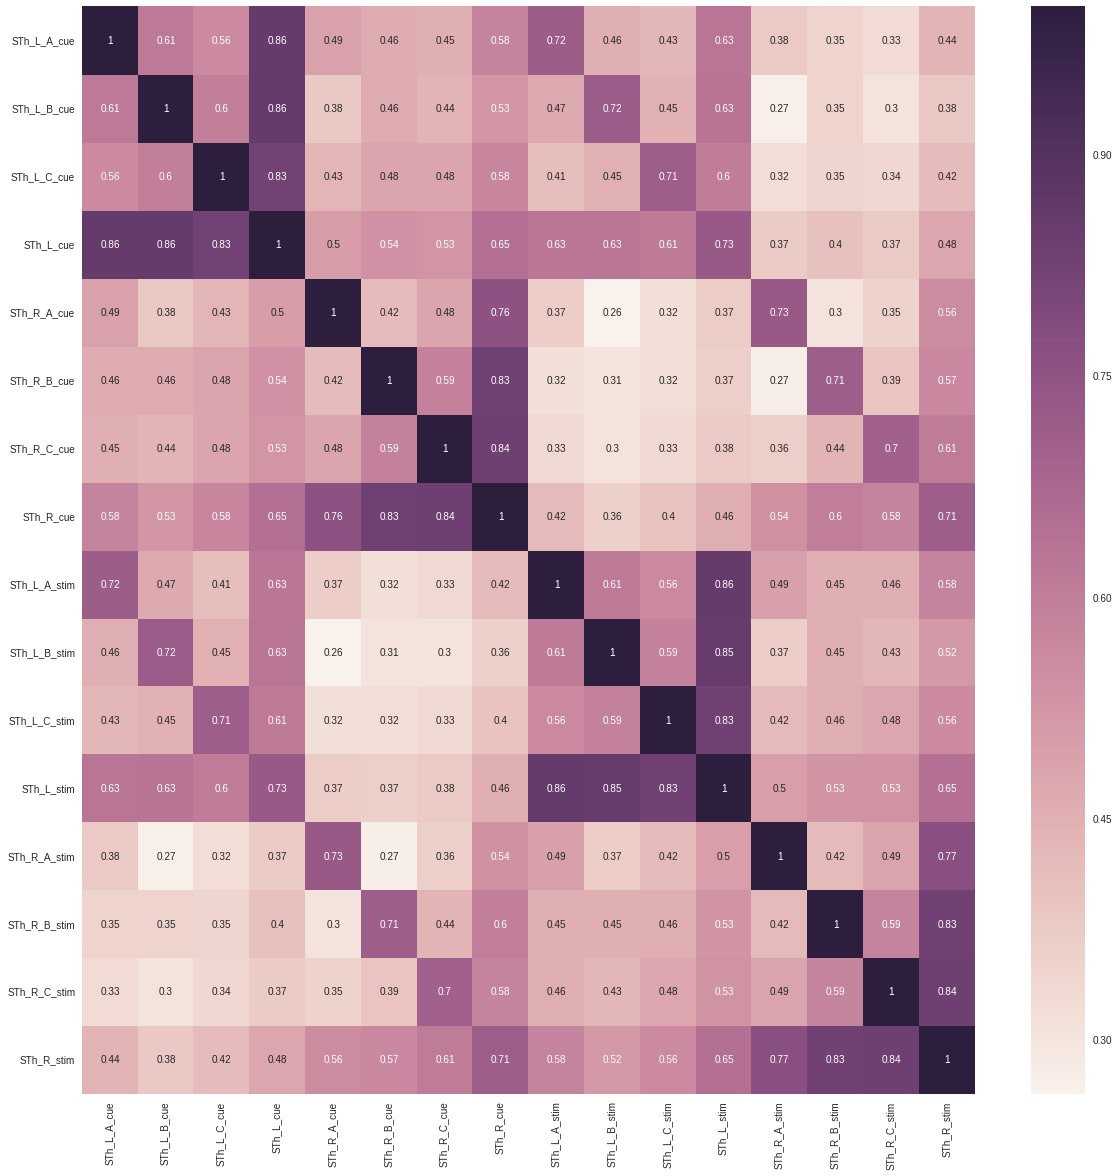

In [20]:
sns.heatmap(df.corr().iloc[-16:, -16:], annot=True)

plt.gcf().set_size_inches((20, 20))

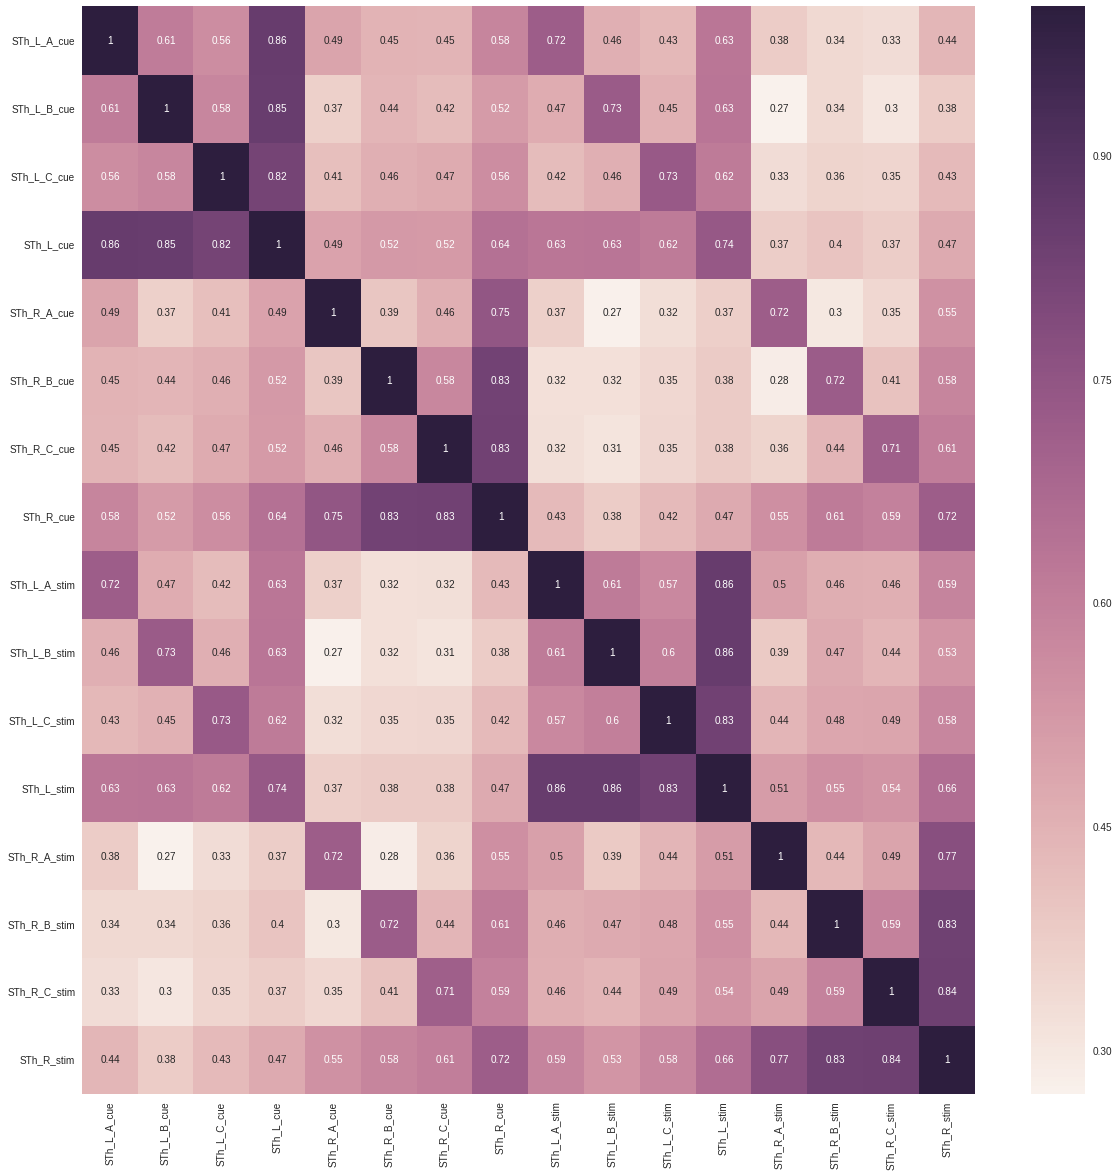

In [129]:
sns.heatmap(df.corr().iloc[-16:, -16:], annot=True)

plt.gcf().set_size_inches((20, 20))

In [21]:
df.to_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

In [22]:
df3 = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates_3s.pandas')
df1_5 = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

In [26]:
tmp = df1_5.merge(df3, left_index=True, right_index=True)

In [30]:
tmp.head()

,block_x,trial_NR_x,cue_delay_x,stim_delay_x,cue_x,coherence_x,difficulty_x,stimulus_x,response_x,rt_x,...,STh_R_C_cue_y,STh_R_cue_y,STh_L_A_stim_y,STh_L_B_stim_y,STh_L_C_stim_y,STh_L_stim_y,STh_R_A_stim_y,STh_R_B_stim_y,STh_R_C_stim_y,STh_R_stim_y
0,1,1,750,1750,neutral,0.08,hard,left,-1,NaN,...,1.734490,0.602382,5.943957,4.597142,2.777253,4.541618,4.017826,2.090487,3.953879,3.106693
1,1,2,0,1000,right,0.16,easy,left,2,720.0,...,-0.234407,0.185193,1.816784,1.162993,2.414038,1.875315,2.864761,0.528413,1.118166,1.202232
2,1,3,1500,1000,left,0.16,easy,left,1,486.0,...,-1.527146,-0.110078,-0.903469,-0.358014,0.560539,-0.278788,0.319444,0.265799,-0.905840,-0.123429
3,1,4,750,1750,neutral,0.16,easy,left,2,689.0,...,-0.573978,-0.688172,-1.411805,-0.762861,0.186377,-0.725182,-2.161442,-1.306573,-0.728812,-1.307654
4,1,5,1500,1000,neutral,0.16,easy,left,1,1339.0,...,-2.142813,-0.942222,-0.705967,2.217979,0.268267,0.411101,-1.405034,0.520549,-0.939058,-0.341657


In [35]:
tmp.groupby(['subject_id_x', 'block_x']).apply(lambda x: sp.stats.pearsonr(x['STh_R_C_stim_y'], x['STh_R_C_stim_x'])[0])

subject_id_x  block_x
1             1          0.894415
              2          0.910495
              3          0.914337
2             1          0.925105
              2          0.883071
              3          0.941323
3             1          0.921235
              2          0.918199
              3          0.924959
4             1          0.935734
              2          0.909956
              3          0.928751
5             1          0.917098
              2          0.934768
              3          0.923533
6             1          0.931208
              2          0.918387
7             1          0.900562
              2          0.893647
              3          0.928730
8             1          0.851597
              2          0.934255
              3          0.934624
9             1          0.926659
              2          0.895804
              3          0.922542
10            1          0.918561
              2          0.903396
              3          0

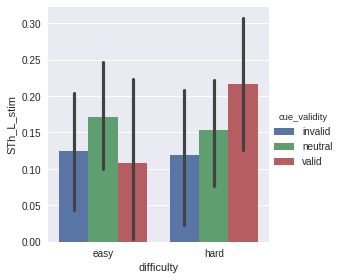

In [36]:
sns.factorplot('difficulty', 'STh_L_stim', 'cue_validity', data=df.groupby(['subject_id', 'difficulty', 'cue_validity'], as_index=False).mean(), units='subject_id', kind='bar')

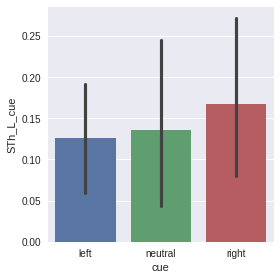

In [37]:
sns.factorplot('cue', 'STh_L_cue', data=df.groupby(['subject_id', 'cue'], as_index=False).mean(), units='subject_id', kind='bar')

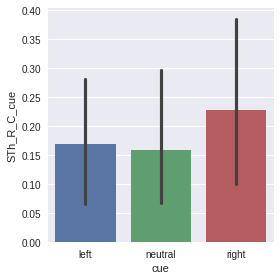

In [41]:
sns.factorplot('cue', 'STh_R_C_cue', data=df.groupby(['subject_id', 'cue'], as_index=False).mean(), units='subject_id', kind='bar')